# MODELING

In [596]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import pandas as pd
import os
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import itertools

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch import nn
import torch.optim as optim
import time

#### Add Mac acceleration

In [597]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


### Dataset class

In [598]:
class MultiParticipantDataset(Dataset):
    def __init__(self, df, seq_length, target_col='mood', id_col='id_num', include_target_in_features=True):
        """
        df: pandas DataFrame sorted by time.
        seq_length: number of time steps in each sample.
        target_col: the column we want to predict.
        """
        df = df.drop(columns=["next_day", "next_day_mood", "date"])
        
        self.seq_length = seq_length
        self.target_col = target_col
        self.id_col = id_col
        
        df.sort_values(by=[id_col, 'day'], inplace=True)
        self.data = df.reset_index(drop=True)

        if include_target_in_features:
            self.features = [col for col in self.data.columns if col not in [target_col, "day"]]
        else:
            self.features = [col for col in self.data.columns if col not in [target_col, id_col, "day"]]

        # Precompute valid indices where the sequence is within the same participant.
        self.valid_indices = []
        for i in range(len(self.data) - self.seq_length):
            participant_id = self.data.iloc[i][self.id_col]
            if all(self.data.iloc[i:i+self.seq_length][self.id_col] == participant_id):
                self.valid_indices.append(i)

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        # Use precomputed valid index.
        real_idx = self.valid_indices[idx]
        row = self.data.iloc[real_idx]
        participant_id = row[self.id_col]
        
        x_features = self.data.iloc[real_idx:real_idx+self.seq_length][self.features].values.astype(np.float32)
        x_id = np.array([participant_id] * self.seq_length, dtype=np.int64)
        
        # The target is the next time step's mood
        y = self.data.iloc[real_idx+self.seq_length][self.target_col]
        
        return torch.tensor(x_features),torch.tensor(x_id), torch.tensor(y).float()


### Load df

In [599]:
df = pd.read_csv("tables/preprocessed/df_interpolated.csv")

dataset_name = "df_interpolated"
dropped_vars = [""]
imputation = "linear interpolation"

# df = pd.read_csv("tables/preprocessed/df_drop_appCat.csv")

# dataset_name = "df_drop_appCat"
# dropped_vars = ["appCat", "sms", "call"]
# imputation = "drop appCat"

### Train test split

In [600]:
# dfs_train = []
# dfs_test = []
# proportion_train = 0.8

# for participant, group in df.groupby('id_num'):
#     group = group.sort_values(by='day')
#     # Calculate the split index based on the proportion
#     split_idx = int(len(group) * proportion_train)
#     # Ensure that the test set has at least seq_length + 1 samples
#     if len(group) - split_idx < seq_length + 1:
#         # Adjust the split index accordingly
#         split_idx = len(group) - (seq_length + 1)
#     if split_idx <= 0:
#         # Option: Skip this participant if not enough data
#         continue
#     dfs_train.append(group.iloc[:split_idx])
#     dfs_test.append(group.iloc[split_idx:])

# train_df = pd.concat(dfs_train)
# test_df = pd.concat(dfs_test)

# SPLIT ACROSS PARTICIPANTS

# Extract unique participant IDs
participant_ids = df['id_num'].unique()

# Split participants (e.g., 80% train, 20% test)
train_ids, test_ids = train_test_split(participant_ids, test_size=0.2, random_state=42)
print(f"Train IDs: {train_ids}")
print(f"Test IDs: {test_ids}")

# Filter the original DataFrame based on these IDs
train_df = df[df['id_num'].isin(train_ids)].copy()
test_df = df[df['id_num'].isin(test_ids)].copy()

# Optional: sort your data by participant and day if not already sorted
train_df.sort_values(by=['id_num', 'day'], inplace=True)
test_df.sort_values(by=['id_num', 'day'], inplace=True)


# get mood descriptives
print("Train mood descriptives")
print(train_df["mood"].describe())
print("Test mood descriptives")
print(test_df["mood"].describe())

# get the start end end dates per participant per df
train_start_dates = train_df.groupby('id_num')['day'].min()
train_end_dates = train_df.groupby('id_num')['day'].max()
test_start_dates = test_df.groupby('id_num')['day'].min()
test_end_dates = test_df.groupby('id_num')['day'].max()

# put in a dataframe with participant train start end and test start end
dates_df = pd.DataFrame({
    "participant": train_start_dates.index,
    "train_start": train_start_dates.values,
    "train_end": train_end_dates.values,
    "test_start": test_start_dates.values,
    "test_end": test_end_dates.values,
})

dates_df.to_csv("tables/training_dates_split.csv", index=False)

Train IDs: [23 24 16 31  2  6  7  3 20 29  5 32 30 25 33 27  9 14 19 26  8]
Test IDs: [12 17 13 28  1 15]
Train mood descriptives
count    1000.000000
mean        6.994925
std         0.749789
min         3.000000
25%         6.600000
50%         7.000000
75%         7.500000
max         9.333333
Name: mood, dtype: float64
Test mood descriptives
count    296.000000
mean       7.010726
std        0.666229
min        3.500000
25%        6.600000
50%        7.000000
75%        7.400000
max        8.800000
Name: mood, dtype: float64


ValueError: All arrays must be of the same length

### Normalize

In [603]:
def normalize(df, scaler=None, scaler_target=None, transform_target=False, scaler_type="StandardScaler"):
    df = df.copy()
    features = [col for col in df.columns if col not in ['id_num', 'day', "date", "next_day_mood", "next_day", "mood"]]
    
    if scaler is None:
        if scaler_type == "StandardScaler":
            scaler = StandardScaler()
        elif scaler_type == "MinMaxScaler":
            scaler = MinMaxScaler()
    
    # Scale the features
    df[features] = scaler.fit_transform(df[features])
    
    if transform_target:
        if scaler_target is None:
            if scaler_type == "StandardScaler":
                scaler_target = StandardScaler()
            elif scaler_type == "MinMaxScaler":
                scaler_target = MinMaxScaler()

        # Scale only the target column "mood"
        df["mood"] = scaler_target.fit_transform(df[["mood"]])

        # print("scaler properties:")
        # print(scaler.mean_)
        # print(scaler.scale_)
        if scaler_type == "StandardScaler":
            print("scaler properties:")
            print(scaler.mean_)
            print(scaler.scale_)
        
        return df, scaler, scaler_target
    else:
        return df, scaler, None

# def denormalize(df, scaler, scaler_target=None):

#     features = [col for col in df.columns if col not in ['id_num', 'day', "date", "next_day_mood", "next_day", "mood"]]
    
#     # Inverse transform the features
#     df[features] = scaler.inverse_transform(df[features])
    
#     if scaler_target is not None:
#         # Inverse transform the target column "mood"
#         df["mood"] = scaler_target.inverse_transform(df[["mood"]])
    
    # return df

TRANSFORM_TARGET = True
SCALER_TYPE = "MinMaxScaler"
# SCALER_TYPE = "StandardScaler"
# Normalize the training and test data
train_df_normalized, scaler, scaler_target = normalize(train_df, scaler=None, scaler_target=None, transform_target=TRANSFORM_TARGET, scaler_type=SCALER_TYPE)
test_df_normalized, _, _ = normalize(test_df, scaler=scaler, scaler_target=scaler_target, transform_target=TRANSFORM_TARGET, scaler_type=SCALER_TYPE)

print(f"Train shape: {train_df_normalized.shape}, Test shape: {test_df_normalized.shape}") # Train shape: (1230, 24), Test shape: (307, 24)



Train shape: (1000, 29), Test shape: (296, 29)


### Create dataset

In [604]:

# Create the dataset
seq_length = 5
batch_size = 64
train_dataset = MultiParticipantDataset(train_df_normalized, seq_length=seq_length)
test_dataset = MultiParticipantDataset(test_df_normalized, seq_length=seq_length)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Check the shape of the data
print(f"Number of batches in train_loader: {len(train_loader)}")
print(f"Number of batches in test_loader: {len(test_loader)}")
for x, x_id, y in train_loader:
    print(f"x shape: {x.shape}, x_id shape: {x_id.shape}, y shape: {y.shape}")
    break
# 32 sequences in a batch, each with 5 time steps and 24 features


Number of batches in train_loader: 15
Number of batches in test_loader: 5
x shape: torch.Size([64, 5, 24]), x_id shape: torch.Size([64, 5]), y shape: torch.Size([64])


### define lstm model

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # LSTM layer; batch_first=True expects input shape: (batch, seq, feature)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        
        # Fully-connected layer to output the final prediction
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # x: [batch_size, seq_length, input_dim]
        # Initialize hidden and cell states with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Use the last time step's output for prediction
        out = self.fc(out[:, -1, :])
        return out



class LSTMModel2(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, output_dim=1, dropout=0.2):
        super(LSTMModel2, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Two-layer LSTM with dropout applied to outputs of each layer (except the last)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        
        # Fully-connected layer to output the final prediction
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # x: [batch_size, seq_length, input_dim]
        batch_size = x.size(0)
        
        # Initialize hidden and cell states with zeros
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)
        
        # Forward propagate LSTM; out shape: [batch_size, seq_length, hidden_dim]
        out, _ = self.lstm(x, (h0, c0))
        
        # Use the last time step's output for prediction; shape: [batch_size, hidden_dim]
        out = out[:, -1, :]
        out = self.fc(out)  # shape: [batch_size, output_dim]
        return out

class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, output_dim=1, dropout=0.2):
        super(GRUModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Two-layer GRU with dropout applied between layers (if num_layers > 1)
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, 
                          batch_first=True, dropout=dropout)
        
        # Fully-connected output layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # x shape: [batch_size, seq_length, input_dim]
        batch_size = x.size(0)
        
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)
        
        # Forward propagate through GRU
        out, _ = self.gru(x, h0)  # out shape: [batch_size, seq_length, hidden_dim]
        
        # Use the output from the last time step for prediction
        out = out[:, -1, :]  # shape: [batch_size, hidden_dim]
        out = self.fc(out)   # shape: [batch_size, output_dim]
        return out


### Train loop

Epoch [1/20], Train Loss: 0.0752, Eval Loss: 0.0802
Epoch [2/20], Train Loss: 0.0218, Eval Loss: 0.0510
Epoch [3/20], Train Loss: 0.0168, Eval Loss: 0.0630
Epoch [4/20], Train Loss: 0.0149, Eval Loss: 0.0460
Epoch [5/20], Train Loss: 0.0151, Eval Loss: 0.0372
Epoch [6/20], Train Loss: 0.0146, Eval Loss: 0.0418
Epoch [7/20], Train Loss: 0.0147, Eval Loss: 0.0420
Epoch [8/20], Train Loss: 0.0136, Eval Loss: 0.0426
Epoch [9/20], Train Loss: 0.0132, Eval Loss: 0.0297
Epoch [10/20], Train Loss: 0.0127, Eval Loss: 0.0401
Epoch [11/20], Train Loss: 0.0130, Eval Loss: 0.0398
Epoch [12/20], Train Loss: 0.0127, Eval Loss: 0.0370
Epoch [13/20], Train Loss: 0.0127, Eval Loss: 0.0379
Epoch [14/20], Train Loss: 0.0127, Eval Loss: 0.0369
Epoch [15/20], Train Loss: 0.0127, Eval Loss: 0.0422
Epoch [16/20], Train Loss: 0.0123, Eval Loss: 0.0357
Epoch [17/20], Train Loss: 0.0118, Eval Loss: 0.0396
Epoch [18/20], Train Loss: 0.0120, Eval Loss: 0.0396
Epoch [19/20], Train Loss: 0.0124, Eval Loss: 0.0481
Ep

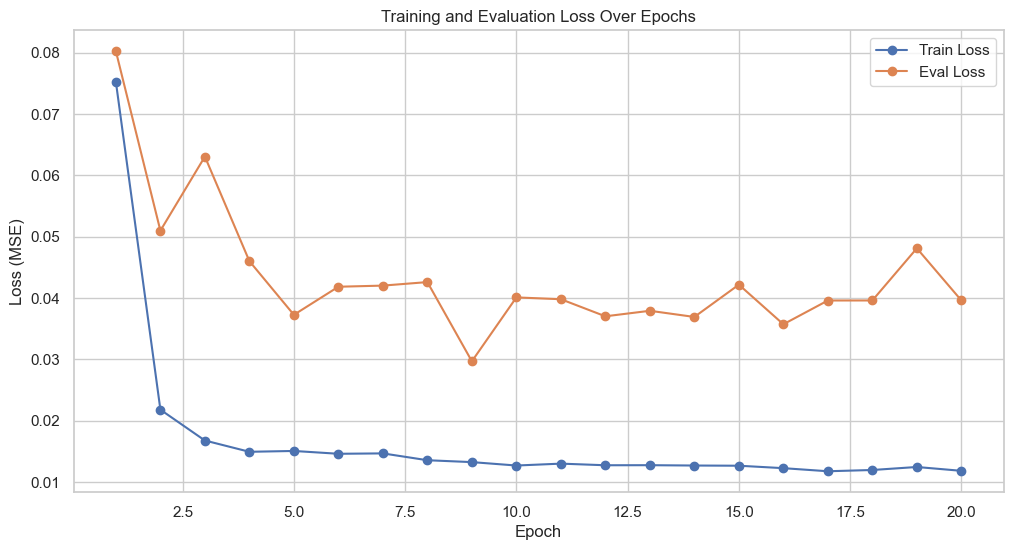

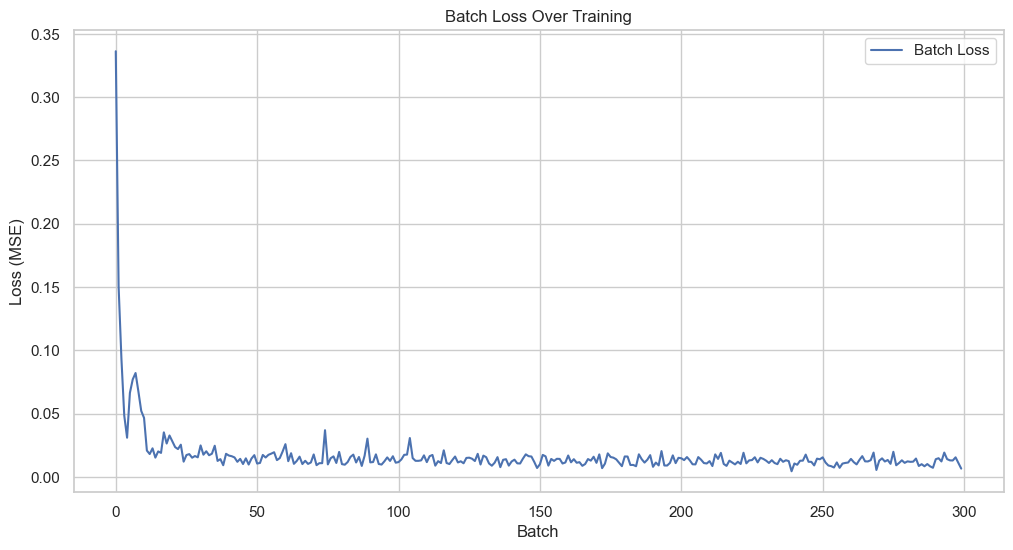

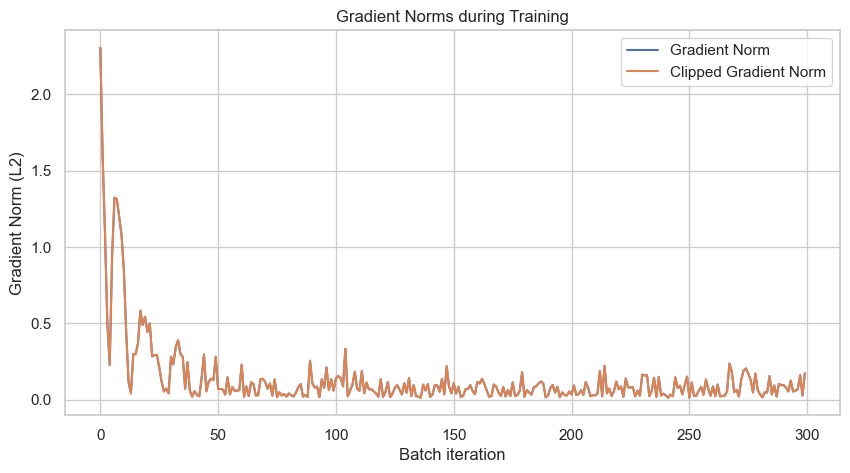

{'dataset': 'df_interpolated', 'dropped_vars': [''], 'imputation': 'linear interpolation', 'model': 'GRU', 'sequence_length': 5, 'scaler': 'MinMaxScaler', 'scaler_target': True, 'batch_size': 64, 'input_dim': 24, 'hidden_dim': 64, 'num_layers': 2, 'output_dim': 1, 'dropout': 0.2, 'num_epochs': 20, 'learning_rate': 0.001, 'train_loss': 0.011824355740100146, 'eval_loss': 0.03959668073803187, 'Features': ['id_num', 'screen', 'activity', 'activity_max', 'circumplex.valence', 'circumplex.valence_min', 'circumplex.valence_max', 'circumplex.arousal', 'circumplex.arousal_min', 'circumplex.arousal_max', 'call', 'sms', 'appCat.builtin', 'appCat.communication', 'appCat.entertainment', 'appCat.finance', 'appCat.game', 'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather'], 'timestamp': '2025-04-07 10:30:41'}


In [605]:
# Hyperparameters
input_dim = len(train_dataset.features)  # e.g., 24
hidden_dim = 64             # Number of LSTM units
num_layers = 2
output_dim = 1                   # For regression (predicting a single value)
num_epochs = 20
learning_rate = 0.001
dropout = 0.2

# Initialize model, loss function, and optimizer
# model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model = LSTMModel2(input_dim, hidden_dim, num_layers, output_dim, dropout)
# model = GRUModel(input_dim, hidden_dim, num_layers, output_dim, dropout)

model = model.to(mps_device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # weight_decay=1e-5)

# Prepare lists to store loss values for plotting
train_epoch_losses = []
eval_epoch_losses = []
batch_losses = []
grad_norms = []  # list to store gradient norms for each batch
clipped_grad_norms = []  # list to store clipped gradient norms for each batch


# Training and evaluation loop
for epoch in range(num_epochs):
    model.train()
    train_loss_epoch = 0.0

    # --- Training ---
    for batch in train_loader:
        x_features, x_id, y = batch  # x_features: [batch, seq_length, input_dim]
        x_features = x_features.to(mps_device)
        x_id = x_id.to(mps_device)
        y = y.to(mps_device)  # y: [batch, output_dim]
        
        # Forward pass
        outputs = model(x_features)  # outputs shape: [batch, output_dim]
        loss = criterion(outputs.squeeze(), y)

        batch_losses.append(loss.item())
        
        # Backprop and optimization
        optimizer.zero_grad()
        loss.backward()

        # Compute total gradient norm
        total_norm = 0.0
        for p in model.parameters():
            if p.grad is not None:
                param_norm = p.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
        total_norm = total_norm ** 0.5
        grad_norms.append(total_norm)
        # Clip gradients
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)  # or another max_norm value

        # Compute clipped gradient norm
        clipped_grad_norm = 0.0
        for p in model.parameters():
            if p.grad is not None:
                param_norm = p.grad.data.norm(2)
                clipped_grad_norm += param_norm.item() ** 2
        clipped_grad_norm = clipped_grad_norm ** 0.5
        clipped_grad_norms.append(clipped_grad_norm)

        optimizer.step()
        
        train_loss_epoch += loss.item()
    
    avg_train_loss = train_loss_epoch / len(train_loader)
    train_epoch_losses.append(avg_train_loss)
    
    # --- Evaluation ---
    model.eval()
    eval_loss_epoch = 0.0
    with torch.no_grad():
        for batch in test_loader:
            x_features, x_id, y = batch
            x_features = x_features.to(mps_device)
            x_id = x_id.to(mps_device)
            y = y.to(mps_device)
            outputs = model(x_features)
            loss = criterion(outputs.squeeze(), y)
            eval_loss_epoch += loss.item()
    
    avg_eval_loss = eval_loss_epoch / len(test_loader)
    eval_epoch_losses.append(avg_eval_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Eval Loss: {avg_eval_loss:.4f}")

# Plot the training and evaluation loss curves
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs+1), train_epoch_losses, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs+1), eval_epoch_losses, label='Eval Loss', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training and Evaluation Loss Over Epochs")
plt.legend()
plt.show()

# plot batch losses
plt.figure(figsize=(12, 6))
plt.plot(batch_losses, label='Batch Loss')
plt.xlabel("Batch")
plt.ylabel("Loss (MSE)")
plt.title("Batch Loss Over Training")
plt.legend()
plt.show()

# plot gradient norms
plt.figure(figsize=(10, 5))
plt.plot(grad_norms)
plt.plot(clipped_grad_norms)
plt.legend(["Gradient Norm", "Clipped Gradient Norm"])
plt.xlabel("Batch iteration")
plt.ylabel("Gradient Norm (L2)")
plt.title("Gradient Norms during Training")
plt.show()



# append the csv with hyperparameters and losses
hyperparameters = {
    "dataset": dataset_name,
    "dropped_vars": dropped_vars,
    "imputation": imputation,
    "model": "GRU",
    "sequence_length": seq_length,
    "scaler": SCALER_TYPE,
    "scaler_target": TRANSFORM_TARGET,
    "batch_size": batch_size,
    "input_dim": input_dim,
    "hidden_dim": hidden_dim,
    "num_layers": num_layers,
    "output_dim": output_dim,
    "dropout": dropout,
    "num_epochs": num_epochs,
    "learning_rate": learning_rate,
    "train_loss": train_epoch_losses[-1],
    "eval_loss": eval_epoch_losses[-1],
    "Features": train_dataset.features,
    "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
}
print(hyperparameters)
hyperparameters_df = pd.DataFrame([hyperparameters])
if not os.path.exists("tables/hyperparameters2.csv"):
    # create the csv with the hyperparameters
    hyperparameters_df.to_csv("tables/hyperparameters2.csv", index=False)
hyperparameters_df = pd.DataFrame([hyperparameters])
hyperparameters_df.to_csv("tables/hyperparameters2.csv", mode='a', header=False, index=False)


### Predict and plot function

In [ ]:

def predict_and_plot(model, data_loader, test_dataset, target_scaler=None, show_plot=True, save_html=True, title="predictions", scaler_type=SCALER_TYPE):
    """
    Runs predictions on the data_loader using model, builds a results DataFrame using the
    test_dataset's original data (which includes the 'day' and 'id_num' columns), and then plots
    real vs predicted values with Plotly using the 'day' column for the x-axis and a dropdown
    to select different participants.

    Parameters:
        model: Trained PyTorch model.
        data_loader: DataLoader for the dataset to predict on.
        test_dataset: The dataset instance (e.g., MultiParticipantDataset) used to create data_loader.
                      It must have a 'data' attribute containing the original DataFrame with a 'day' column.
        target_scaler: (Optional) Scaler used to normalize the target data.
    """
    model.eval()
    all_predictions = []
    all_targets = []

    # move everything to cpu
    model.to("cpu")

    
    # Run model predictions over the data_loader
    with torch.no_grad():
        for batch in data_loader:
            x_features, x_id, y = batch
            x_features = x_features.to("cpu")
            x_id = x_id.to("cpu")
            y = y.to("cpu")
            outputs = model(x_features)
            all_predictions.append(outputs.cpu().numpy())
            all_targets.append(y.cpu().numpy())
    
    # Concatenate all predictions and targets into arrays.
    all_predictions = np.concatenate(all_predictions)
    all_targets = np.concatenate(all_targets)

    # print mean sd, min max of predictions and targets
    print("Predictions mean:", np.mean(all_predictions))
    print("Predictions sd:", np.std(all_predictions))
    print("Predictions min:", np.min(all_predictions))
    print("Predictions max:", np.max(all_predictions))
    print("Targets mean:", np.mean(all_targets))
    print("Targets sd:", np.std(all_targets))
    print("Targets min:", np.min(all_targets))
    print("Targets max:", np.max(all_targets))

    
    # Inverse transform if a target scaler is provided.
    if target_scaler is not None:
        if scaler_type == "StandardScaler":
            print("Target scaler mean:", target_scaler.mean_)
            print("Target scaler scale:", target_scaler.scale_)
        all_predictions = target_scaler.inverse_transform(all_predictions)
        all_targets = target_scaler.inverse_transform(all_targets.reshape(-1, 1))
    

    # Compute the correct slice of the original DataFrame.
    # The i-th prediction corresponds to data row at index (i + seq_length)
    start_idx = test_dataset.seq_length
    end_idx = start_idx + len(test_dataset)
    df_results = test_dataset.data.iloc[start_idx:end_idx].copy().reset_index(drop=True)

    # Add prediction and target columns to the results DataFrame.
    df_results['Real'] = all_targets.reshape(-1)
    df_results['Predicted'] = all_predictions.reshape(-1)
    
    # Get unique participant IDs from the results DataFrame.
    participant_col = test_dataset.id_col  # e.g., 'id_num'
    participants = df_results[participant_col].unique()
    
    # Build Plotly traces for each participant: two traces (real & predicted) per participant.
    traces = []
    for p in participants:
        df_p = df_results[df_results[participant_col] == p]
        traces.append(go.Scatter(
            x=df_p['day'],
            y=df_p['Real'],
            mode='lines',
            name=f'Real ({p})',
            visible=False  # We'll control visibility via the dropdown.
        ))
        traces.append(go.Scatter(
            x=df_p['day'],
            y=df_p['Predicted'],
            mode='lines',
            name=f'Predicted ({p})',
            visible=False
        ))
    
    total_traces = len(traces)  # Should be 2 * number of participants.
    
    # Create dropdown buttons. Each button sets visibility so that only the two traces for one participant are shown.
    dropdown_buttons = []
    for i, p in enumerate(participants):
        visibility = [False] * total_traces
        # For participant p, set traces at indices 2*i and 2*i+1 to True.
        visibility[2*i] = True
        visibility[2*i+1] = True
        button = dict(
            label=str(p),
            method="update",
            args=[{"visible": visibility},
                  {"title": f"Real vs Predicted Mood Values for Participant {p}",
                   "xaxis": {"title": "Day"},
                   "yaxis": {"title": "Mood Value"}}]
        )
        dropdown_buttons.append(button)
    
    # Set the initial visibility: show the first participant.
    initial_visibility = [False] * total_traces
    initial_visibility[0] = True
    initial_visibility[1] = True
    for i in range(total_traces):
        traces[i].visible = initial_visibility[i]
    
    # Build the figure with all traces and add the dropdown menu.
    fig = go.Figure(data=traces)
    fig.update_layout(
        updatemenus=[
            dict(
                active=0,
                buttons=dropdown_buttons,
                x=1.1,
                y=1.0,
                showactive=True
            )
        ],
        title=f"Real vs Predicted Mood Values for Participant {participants[0]}",
        xaxis_title="Day",
        yaxis_title="Mood Value"
    )
    
    if show_plot:
        fig.show()
    if save_html:
        outdir = "figures/plotly/predictions"
        os.makedirs(outdir, exist_ok=True)
        fig.write_html(os.path.join(outdir, f"predictions_{title}.html"))

    # MAE RMSE R2
    mae = mean_absolute_error(all_targets, all_predictions)
    rmse = np.sqrt(mean_squared_error(all_targets, all_predictions))
    r2 = r2_score(all_targets, all_predictions)
    print(f"MAE: {mae}, RMSE: {rmse}, R2: {r2}")
    return df_results, mae, rmse, r2
    
    



### Plot predictions

In [ ]:
# Call the function to predict and plot
predict_and_plot(model, train_loader, train_dataset, target_scaler=scaler_target, show_plot=True, save_html=True, title="train", scaler_type=SCALER_TYPE)
predict_and_plot(model, test_loader, test_dataset, target_scaler=scaler_target, show_plot=True, save_html=True, title="test", scaler_type=SCALER_TYPE)

Predictions mean: 0.358279
Predictions sd: 0.0372927
Predictions min: 0.20763361
Predictions max: 0.4051753
Targets mean: 0.62981737
Targets sd: 0.11937628
Targets min: 0.0
Targets max: 1.0


MAE: 0.2758120000362396, RMSE: 0.29561591430799594, R2: -5.132245063781738
Predictions mean: 0.3566835
Predictions sd: 0.05155187
Predictions min: 0.216602
Predictions max: 0.40320456
Targets mean: 0.6656745
Targets sd: 0.12549633
Targets min: 0.0
Targets max: 1.0


MAE: 0.3130604326725006, RMSE: 0.33845748099170025, R2: -6.273545742034912


(     id_num      mood    screen  activity  activity_max  circumplex.valence  \
 0         1  0.584906  0.649393  0.304616      0.822034            0.533333   
 1         1  0.660377  0.689660  0.439652      0.640000            0.600000   
 2         1  0.547170  0.194661  0.287747      0.638655            0.533333   
 3         1  0.849057  0.329065  0.205074      0.436975            0.666667   
 4         1  0.754717  0.178834  0.086108      0.277778            0.583333   
 ..      ...       ...       ...       ...           ...                 ...   
 266      28  0.622642  0.430252  0.319083      0.658333            0.500000   
 267      28  0.622642  0.389404  0.352576      0.705357            0.466667   
 268      28  0.509434  0.401964  0.107922      0.159664            0.200000   
 269      28  0.811321  0.375260  0.324549      0.458333            0.583333   
 270      28  0.433962  0.415110  0.104490      0.205128            0.333333   
 
      circumplex.valence_min  circumpl